The goal is to extract the date and the IP from the list of abstract files.

We installed the following packages:
* [pycountry](https://pypi.python.org/pypi/pycountry), to work on the name country names;
* [python-geoip](http://pythonhosted.org/python-geoip/), to access to GeoIP databases.

Matplotlib is used to create the figure and shapefile to read the country shapefile.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection
from matplotlib import cm
import shapefile
import matplotlib as mpl
import re
from geoip import geolite2
from collections import Counter
import pycountry
%matplotlib inline

# Input files

In [2]:
countryshapefile = "/home/ctroupin/DataOceano/ShapeFiles/TM_WORLD_BORDERS_SIMPL-0.3/TM_WORLD_BORDERS_SIMPL-03"
abstractfile = './abstractslist2013.txt'
figname = abstractfile[:-4] + '_map'

Extract year from file name using regex

In [3]:
match = re.search(r'\d{4}', abstractfile)
year = match.group()
print("Working on year %s" %(year))

Working on year 2013


# Read the country shape file

In [4]:
r = shapefile.Reader(countryshapefile)
shapes = r.shapes()
records = r.records()

# Create a list of countries from the list of abstracts

We use a regular expression to extract the IP and the date.

In [5]:
countrylist = []
nlines = 0
with open(abstractfile, 'r') as f:
    for lines in f.readlines():
        nlines += 1
        match = re.search(r'(\d{4})-(\d{2})-(\d{2})_(\d{2}):(\d{2}):(\d{2})_IP_(\d+\.\d+\.\d+\.\d+).json', lines)
        if match:
            IP = match.group(7)
            matchIP = geolite2.lookup(IP)
            if matchIP: 
                countrylist.append(matchIP.country)

Check if all the IP are assigned to a country:

In [6]:
print("Number of lines in file: %d" %(nlines))
print("Number of countries identified: %d" %(len(countrylist)))

Number of lines in file: 175
Number of countries identified: 175


It seems two IP were not properly processed.

## Count abstract by country

We simply use [collections.Counter](https://docs.python.org/2/library/collections.html#collections.Counter) in order to get a dictionnary with the countries (2-letter code) as keys and the number of abstracts as the values.

In [7]:
abstract_countrycount = Counter(countrylist)
nmax = float(max(abstract_countrycount.values()))

In [8]:
abstract_countrycount

Counter({'FR': 26, 'GB': 26, 'US': 25, 'BE': 12, 'DE': 12, 'AU': 11, 'ES': 8, 'CA': 7, 'DK': 4, 'NL': 4, 'NO': 3, 'CN': 3, 'CL': 3, 'IT': 3, 'ZA': 3, 'MA': 3, 'FI': 2, 'PT': 2, 'EE': 2, 'IN': 2, 'UA': 2, 'JP': 1, 'DZ': 1, 'RU': 1, 'NG': 1, 'TN': 1, 'RO': 1, 'EG': 1, 'CZ': 1, 'AR': 1, 'ID': 1, 'OM': 1, 'IL': 1})

# Make the plot

Create a colormap and set the limits (to be adapted)

In [43]:
bounds = [1, 2, 4, 6, 8, 10, 15, 20]
cmap = cm.OrRd
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

Create the projection

In [44]:
m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=85,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')

Loop on the all countries

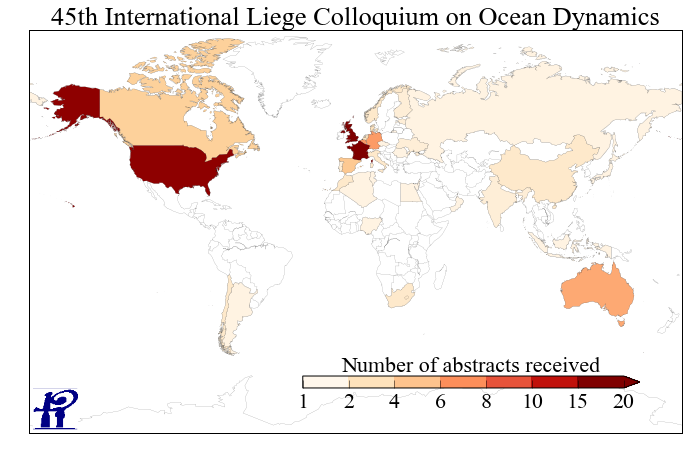

In [45]:
mpl.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(11.7,8.3))
plt.title('45th International Liege Colloquium on Ocean Dynamics')
ax = plt.subplot(111)
m.drawcountries(linewidth=0.1)
m.drawcoastlines(linewidth=0.1)

for record, shape in zip(records,shapes):
    countryname = record[1]
    if countryname in abstract_countrycount:
        lons,lats = zip(*shape.points)
        data = np.array(m(lons, lats)).T
 
        if len(shape.parts) == 1:
            segs = [data,]
        else:
            segs = []
            for i in range(1,len(shape.parts)):
                index = shape.parts[i-1]
                index2 = shape.parts[i]
                segs.append(data[index:index2])
            segs.append(data[index2:])
 
        lines = LineCollection(segs,antialiaseds=(1,))
        lines.set_facecolors(cmap(abstract_countrycount[countryname]/nmax))
        lines.set_edgecolors('k')
        lines.set_linewidth(0.1)
        ax.add_collection(lines)
cax = fig.add_axes([0.45, 0.25, 0.4, 0.02])
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', spacing='uniform',
                                extend='max', label='Number of abstracts received')
cb1.ax.xaxis.set_label_position('top')

im = plt.imread('../logos/logo_colloquium.eps')
newax = fig.add_axes([0.13, 0.18, 0.07, 0.07], anchor='SW')
newax.imshow(im)
newax.axis('off')
plt.savefig(figname, dpi=300)
plt.show()